In [1]:
import pandas as pd
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from functools import reduce
from itertools import accumulate
from functools import wraps
from sklearn.datasets import make_classification
from mpl_toolkits.mplot3d import Axes3D 
import warnings
from sklearn.utils import shuffle

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import visualizacoes as vs
from utils import get_hyperplane, Classificador

No notebook passado introduzimos tarefas de classificação: grupos de dados que estão segmentados conforme suas respectivas classes e que precisam ser clasisifcados conforme essa classe. Vimos como podemos aplicar um modelo linear para quantificar a propensão de cada sample a uma determinada classes (que chamamos de classe positiva 1) vs a propensão da classe negativa 0, e a partir desse modelo, traçar uma separatória, um threshold para determinar as superfícies de decisão. 

Neste notebook, vamos formalizar 

## Neurônio artificial Perceptron



Um perceptron busca simular a transferência de informação de um neurônio natural através de uma equação de regressão linear: Primeiro é realizada a somatória dos __produtos__ dos input $x$ por seus respectivos pesos $w$ (ou também chamado de __beta__, coeficiente angular, $\beta$ no caso de regressões) e por fim acrescentado um __bias__ (intercept, ou ainda, coeficiente linear)

<img src='https://miro.medium.com/max/645/0*LJBO8UbtzK_SKMog' width='500px'>

### Funções de Ativação

Perceptrons se diferenciam de regressões lineares pois são efetivamente algoritmos de classificação. Para que a saída classificatória seja possível, a saída regressiva (função de soma demonstrada acima) precisa ser transformada por uma segunda função, geralmente chamada de função de ativação do neurônio (inclusive, é essa terminologia que você encontrará nos frameworks de deep learning): 

<img src='https://miro.medium.com/max/640/1*8VSBCaqL2XeSCZQe_BAyVA.jpeg' width='500px'>

Muitas funções de ativação diferentes foram testadas ao longos dos anos. Em especial, duas são bastante utilizadas: a Sigmoide, Tanh e a ReLU (Rectified Linear Unit). Existem motivos mais complexos relacionados ao treinamento de uma rede neural que fizeram com que a ReLU passasse a ser mais utilizadas nos últimos anos, mas isso será melhor compreendido mais a frente. 

#### Step function

Em geral, a primeira função que foi utilizada para ativer perceptrons é uma função de sinal simples, também chamada de __step function__, que é uma interpretação simples de um valor. Ele será -1 se for menor que 0, +1 se for maior que zero, e 0 se for simplesmente 0:

$$ \normalsize \varphi(z) = \left\{\begin{matrix}-1 \text{    se } z < 0,\\0 \text{    se } z = 0,\\ 1 \text{    se } z > 0,\end{matrix}\right.$$

vamos criar uma step function e testar, mas antes disso, precisamos resolver algo. Dissemos acima que é ideal ao máximo vetorizar as operações. Quando temos funções matemáticas que dependem do teste de condições (como é o caso da step function) no entanto, surge um problema de lógica de programação, pois a função pode testar um valor indivual de $x$ contra as condições acima, mas ela não é capaz de testar as condições em um vetor de valores caso queiramos aplicá-la diretamente no vetor, onde o resultado da condição seria ambíguo. Para isso criamos um decorador abaixo que decora as funções de ativação que criaremos e testa se estamos passando para ela um escalar único ou um vetor de valores, e a função se adaptará de acordo:

In [4]:
def unit_step_function(X, threshold=0):
    return np.array([1 if z > threshold else 0 for z in X])

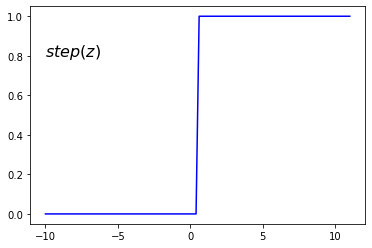

In [5]:
graph = plt.plot(np.linspace(-10,11,100), unit_step_function(np.linspace(-10,10,100)), color='blue')
p = plt.text(-10, .8, r'$step(z)$', fontsize=16)

In [6]:
def predict(X, W, b=None):
    bias = 0 if b is None else b
    X = np.expand_dims(X, axis=0) if X.ndim == 1 else X
    z = np.dot(X, W) + bias
    return unit_step_function(z)

### Algoritmo de aprendizagem do perceptron

![image alt ><](imgs/perceptron_learning_algorithm.png)

Repare que o algoritmo descrito acima não trabalha diretamente com a previsão final do perceptron, mas sim a transferência $wx$. Sabemos que quando $wx >= 0$, a previsão do modelo será 1, senão, 0. Para facilitar a compreensão sobre o algoritmo, vamos substituir $wx$ pelo termo $y_{\text{pred}}$ que representa a previsão final do modelo, e chamaremos de $y_{\text{real}}$ o valor real esperado. Continuando, o algoritmo propõe 3 situações distintas: 

(1) $$\normalsize \text{ se } y_{\text{pred}} = 0 \text{ ; } y_{\text{real}} = 1: {w}' \leftarrow w + x$$

(2) $$\normalsize \text{ se } y_{\text{pred}} = 1 \text{ ; } y_{\text{real}} = 0: {w}'\leftarrow w - x$$

(3) $$\normalsize \text{ senão }: {w}' \rightarrow w $$

### Racional por trás do algoritmo

Vamos considerar um cenário hipotético bem simples e visual para entendermos perfeitamente o que está acontecendo aqui. Criamos um vetor de pesos $\vec{w}$ e uma matriz de observações $X$: 

In [7]:
def update_weight(x, y, W, b=None):
    y_pred = predict(x, W, b)

    if y_pred == 0 and y == 1:
        w_new = W + x
        
    elif y_pred == 1 and y == 0:
        w_new = W - x
        
    else:
        w_new = W
        
    return w_new, W

In [8]:
X = np.array([[1,2], [-1,2], [0,-1]])
vs.display_matrix(X, label='X')

<br>$X = \begin{bmatrix}1&2\\-1&2\\0&-1\end{bmatrix}$<br><br>

Dimensões da matriz: (3 x 2)



Estamos trabalhando com classificação, então criamos também um vetor resposta $Y$:

In [9]:
Y = np.array([1, 0, 0])

In [10]:
vs.display_vec(Y, 'Y')

<br>$Y = \begin{bmatrix}1\\0\\0\end{bmatrix}$<br>

Por fim, criamos um vetor de pesos $W$ 

In [11]:
W = np.array([1, -0.8])

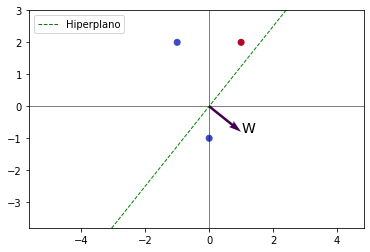

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm)
vs.plot_hyperplane(get_hyperplane(W, 0), x=np.linspace(-4,4,5))
vs.plot_vecs(W, 'W')

# Primeira interação do algoritmo

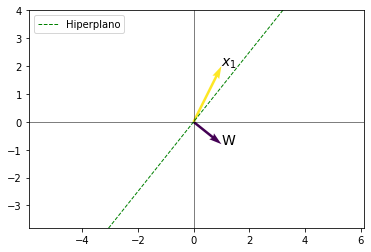

In [13]:
vs.plot_hyperplane(get_hyperplane(W, 0), x=np.linspace(-4,4,5))
vs.plot_vecs([W, X[0]], ['W', '$x_1$'])

O valor real de Y para esse datapoint é 1:

In [14]:
Y[0]

1

Como já sabemos pela superfície de decisão plotada anteriormente, o modelo deve retornar uma previsão errada para esse ponto. Confirmando que $y_{\text{pred}} = 0$:

In [15]:
predict(X[0], W)

array([0])

O modelo gerou uma previsão errada, onde o rótulo real é da classe 1, mas o modelo retornará 0 uma vez que $wx_1 + b < 0$. Isso configura a primeira situação descrita no algoritmo de treinamento do Perceptron:

$$\normalsize \text{ se } y_{\text{pred}} = 0 \text{ ; } y_{\text{real}} = 1: {w}' \rightarrow w + x$$

Vamos atualizar $W$ conforme a regra, somando o vetor atual com o input $x_1$:

In [16]:
W_new, W_old = update_weight(X[0], Y[0], W)

#### Mas porque exatamente somamos os vetores?

Quando somamos dois vetores $\vec{u}$ e $\vec{v}$, estamos fazendo a seguinte operação:

<img src='imgs/vector_sum.png'>

Trazendo isso para nosso contexto, somar o input ao vetor de pesos faz com que o vetor de pesos resultante se aproxime do vetor de input, de forma que o novo hiperplano gerado esteja à esquerda do input $x_1$. Se o hiperplano está a esquerda, sabemos que o modelo atribuirá a esse ponto a classificação positiva. Veja no plot abaixo como o novo vetor de pesos ${W}'$ se apróxima de $x_1$, e por consequência, o novo hiperplano é rotacionado para classificar corretamente $x_1$:

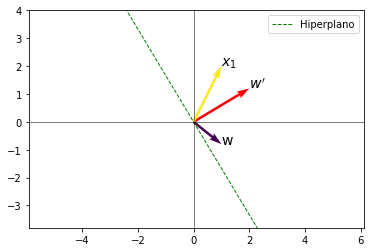

Nova classificação do ponto x1: 1


In [17]:
vs.plot_hyperplane(get_hyperplane(W_new, 0))
plt.quiver(0, 0, W_new[0], W_new[1], angles='xy', scale_units='xy', scale=1, color='red')
plt.text(W_new[0], W_new[1], "${w}'$", fontsize=14)
vs.plot_vecs([W_old, X[0]], ["w", '$x_1$'])

print('Nova classificação do ponto x1: %d' % predict(X[0], W_new)[0])

#### Segunda interação

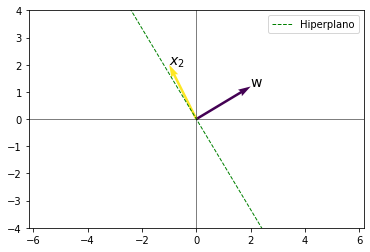

Valor resposta real: 0
Valor previsto pelo modelo: 1


In [18]:
vs.plot_hyperplane(get_hyperplane(W_new, 0), x=np.linspace(-4,4,5))
vs.plot_vecs([W_new, X[1]], ["w", '$x_2$'])
print('Valor resposta real: %d' % Y[1])
print('Valor previsto pelo modelo: %d' % predict(X[1], W_new)[0])

Como podemos ver, após atualizar o vetor de pesos com o primeiro datapoint, o hiperplano novo passou a classificar o único ponto que estava sendo corretamente classificado pelo vetor inicial. Temos a segunda situação descrita pelo algoritmo:

$$\normalsize \text{ se } y_{\text{pred}} = 1 \text{ ; } y_{\text{real}} = 0: {w}'\rightarrow w - x$$

Analogamente a somatória de vetores, subtrair um vetor de outro fará com que o vetor resultante se afaste de $x_1$. Ao rotacionar o vetor de pesos dessa forma, englobaremos novamente o ponto $x_2$ de volta para a superfície de classificação negativa:

In [18]:
W_new, W_old = update_weight(X[1], Y[1], W_new)

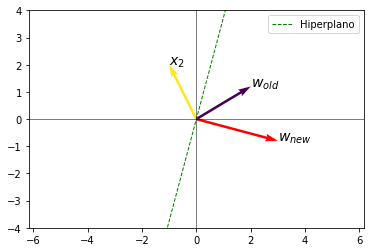

Nova classificação do ponto x2: 0


In [19]:
vs.plot_hyperplane(get_hyperplane(W_new, 0))
plt.quiver(0, 0, W_new[0], W_new[1], angles='xy', scale_units='xy', scale=1, color='red')
plt.text(W_new[0], W_new[1], "$w_{new}$", fontsize=14)
vs.plot_vecs([W_old, X[1]], ["$w_{old}$", '$x_2$'])

print('Nova classificação do ponto x2: %d' % predict(X[1], W_new)[0])

#### Terceira interação do algoritmo

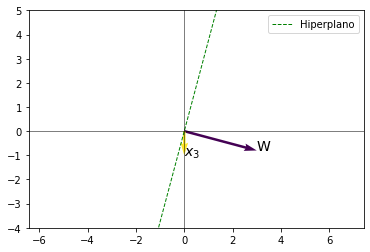

Valor resposta real: 0
Valor previsto pelo modelo: 1


In [20]:
vs.plot_hyperplane(get_hyperplane(W_new, 0), x=np.linspace(-4,4,5))
vs.plot_vecs([W_new, X[2]], ['W', '$x_3$'])
print('Valor resposta real: %d' % Y[2])
print('Valor previsto pelo modelo: %d' % predict(X[2], W_new)[0])

In [21]:
W_new, W_old = update_weight(X[2], Y[2], W_new)

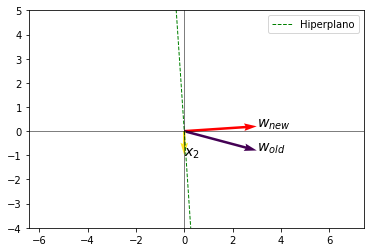

Nova classificação do ponto x2: 0


In [22]:
vs.plot_hyperplane(get_hyperplane(W_new, 0))
plt.quiver(0, 0, W_new[0], W_new[1], angles='xy', scale_units='xy', scale=1, color='red')
plt.text(W_new[0], W_new[1], "$w_{new}$", fontsize=14)
vs.plot_vecs([W_old, X[2]], ["$w_{old}$", '$x_2$'])

print('Nova classificação do ponto x2: %d' % predict(X[2], W_new)[0])

In [23]:
vs.display_vec(W_new, 'W')

<br>$W = \begin{bmatrix}3\\0.20\end{bmatrix}$<br>

Após as 3 interações, ajustamos o modelo aos dados. Nosso modelo final ficou:

$$\normalsize y = 3x_1 + 0.2x_2$$

Que por sinal, segue um racional bem semelhante ao modelo linear que introduzimos no vídeo passado, um onde a variável do eixo $x$ é bem mais explicativa em relação a variável do eixo $y$. Isso fica aparente quando plotamos a superfície de decisão do modelo ajustado:

In [24]:
def perceptron(X):
    W = np.array([3, 0.2])
    z = np.dot(X,W)
    return unit_step_function(z)

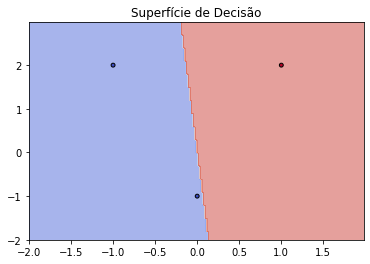

In [25]:
vs.plot_superficie_decisao(Classificador(perceptron), X, Y)

#### Erro e função de custo do perceptron

O erro no contexto de aprendizagem supervisionada é a diferença entre o resultado esperado e o resultado retornado pelo modelo. É bastante comum o erro ser chamado de __função de custo__ também, e existem diferentes equações e fórmulas para se contabilizar o custo. Nesse simples caso do perceptron, vamos quantificar o erro exatamente pela definição simples que demos:

(1) $$\normalsize e = y_{\text{real}} - y_{\text{pred}}$$

Onde $y_{\text{real}}$ representa o valor resposta original e $y_{\text{pred}}$ representa o valor previsto pelo modelo. Temos três valores posíveis pra $e$ no nosso caso:

Falso positivo, ou erro do tipo I, que ocorre quando o modelo preve um valor como positivo (1) sendo que ele era negativo:

$$\normalsize e = 0 - 1 \therefore  e = -1$$

Falso negativo, ou erro do tipo II, que ocorre quando o modelo preve um valor como negativo (0) sendo que ele era positivo:

$$\normalsize e = 1 - 0 \therefore  e = 1$$

E finalmente, a situação que queremos, quando não há erro:

$$\normalsize e = 1 - 1 \therefore  e = 0$$

Ou então:

$$\normalsize e = 0 - 0 \therefore  e = 0$$

Com essa definição, podemos consciliar isso com as 3 situações descritas no algoritmo de aprendizagem inicial e transformá-lo em uma única equação:

$$\normalsize {w}' = w + \Delta w$$

Onde $\Delta w = ex$, ficando assim com a equação abaixo:

(2) $$\normalsize {w}' = w + (y_{\text{real}} - y_{\text{pred}})x$$

Essa equação substitui as 3 condições descritas no primeiro algoritmo de aprendizagem. Repare que o sinal do erro é o que faz a mágica. Repare o que ocorre com a equação para cada um dos 3 casos possíveis:

Se tivermos falsos positivos ($e = -1$):

$$\normalsize {w}' = w + -1x = w - x $$

Já percebeu onde queremos chegar correto? Se tivermos um falso negativo ($e = 1$):

$$\normalsize {w}' = w + 1x = w + x $$

E finalmente, se não houver erro ($e = 0$) e precisamos manter $w$:

$$\normalsize {w}' = w + 0x = w $$

Podemos atualizar o __bias__ de um perceptron da mesma forma. O bias no final do dia é um peso cujo input será sempre 1:

$$\normalsize {b}' = b + e$$



In [26]:
class Perceptron_Simples:
    
    def __init__(self):
        self.step_function = lambda Z: np.array([1 if z_i >= 0 else 0 for z_i in Z])

    def fit(self, X, Y):

        self.W = np.random.rand(X.shape[1])
        self.b = np.random.rand(1)

        i = 1
        
        convergencia = False
        
        while not convergencia:

            sample = np.random.choice(X.shape[0], 1, replace=True)[0]
            x_i, y_i = X[sample], Y[sample]
            y_hat = 1 if np.dot(x_i, self.W) + self.b >= 0 else 0
            self.W += (y_i - y_hat) * x_i
            self.b += (y_i - y_hat)
            preds = unit_step_function(np.dot(X, self.W) + self.b)
            convergencia = not bool(sum(abs(Y - preds)))
            i += 1
            
        print('Algoritmo convergiu após %d interações' % i)


    def predict(self, X):
        Z = np.dot(X, self.W) + self.b
        return self.step_function(Z)

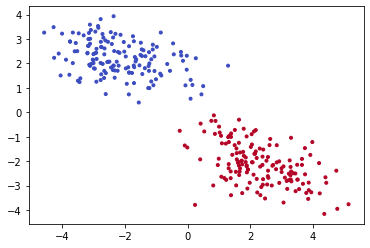

In [27]:
X, Y = make_classification(
    n_samples=300, 
    n_features=2,
    n_redundant=0,
    class_sep=2.2,
    n_clusters_per_class=1,
    flip_y=0,
    random_state=8,
    n_classes=2
)
vs.scatter_plot(X,Y)

In [28]:
clf = Perceptron_Simples()

In [32]:
clf.fit(X, Y)

Algoritmo convergiu após 5 interações


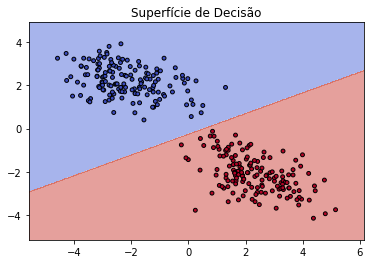

In [33]:
vs.plot_superficie_decisao(clf, X, Y)

### 4. Referência bibliográfica

Learning and Generalization in Single Layer Perceptrons. Neural Computation : Lecture 4. John A. Bullinaria, 2015

4 - Perceptron Learning Rule. Martin Hagan, http://hagan.okstate.edu/4_Perceptron.pdf